# NYC Taxi Fare & Tip Prediction with Linear Models
---

## Project Overview

### Summary  
In this project, I’m building a practical machine learning pipeline using real NYC taxi trip data. My goal is to take a messy, high-volume dataset and turn it into two working prediction models—one for fare amounts and one for tip likelihood. This gives me a chance to work with realistic data while keeping the modeling approach simple and approachable.

### Objective  
- I want to **predict the total fare amount** for each trip using linear regression.  
- I also want to **predict whether a passenger leaves a tip** using logistic regression.  
- I’m focusing on **baseline linear models** because they help me understand the data before I move on to more advanced techniques in future projects.

### Data Source  
- **Dataset Name:** NYC Yellow Taxi Trip Records  
- **Provider:** NYC Taxi & Limousine Commission (TLC)  
- **Official Source:** https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page  
- **Kaggle Mirror:** https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

### Deliverables  
#### By the end of this project, I want to have:

- A cleaned and preprocessed taxi trip dataset  
- A **linear regression model** predicting fare amount with solid evaluation metrics (RMSE, MAE, R²)  
- A **logistic regression model** predicting tip/no-tip, evaluated with accuracy, precision, recall, and ROC-AUC  
- Hyperparameter-tuned versions of each model using regularization  
- A simple **deployment-style prediction function** that can take raw inputs and return fare and tip predictions  
- A brief **monitoring and maintenance plan** to explain how I would keep this model healthy if this were a real system


# Installations
---

Before I start working with the NYC taxi dataset, I want to make sure my environment has all of the libraries I need. I’m pinning every version so my notebook stays reproducible, and so I can avoid unexpected breaking changes later on. I’m also installing PyTorch with CUDA 11.8 so I can train models on the GPU whenever possible.

### What I'm Installing
- core data science tools (pandas, numpy, matplotlib, seaborn)  
- modeling libraries (scikit-learn)  
- GPU-ready PyTorch  
- utilities for preprocessing, evaluation, and deployment  
- tqdm for progress bars

In [1]:
# !pip install -r requirements.txt --quiet

### Environment Setup
Now I load PyTorch with CUDA 11.8 support and confirm that my GPU is available before I move on.

In [2]:
# PyTorch GPU verification

import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))



PyTorch version: 2.2.2+cu118
CUDA available: True
Device: cuda


# Data Collection
---
- I’m loading the NYC taxi trip data from **multiple Parquet files** stored in my local `data/` directory.  
- I combine all files into a single DataFrame for analysis.  
- I keep a separate copy of the raw DataFrame so I always have the untouched source data available.



In [3]:
import pandas as pd
import glob

# Path to local Parquet files
data_path = "data/*.parquet"

# Collect all Parquet file paths
parquet_files = glob.glob(data_path)
print("Files found:", len(parquet_files))

# Load and combine
df_list = [pd.read_parquet(f) for f in parquet_files]
df_raw = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df_raw.shape)

# Keep a backup of the untouched raw data
df_original = df_raw.copy()


Files found: 1
Combined shape: (3475226, 20)


# Exploratory Data Analysis (EDA)
---
- Perform a quick structural check of the combined dataset.  
- Inspect column names, data types, and basic statistics.  
- Identify obvious issues such as missing values, zero distances, incorrect timestamps, or unrealistic fares.  
- Generate simple visualizations to understand distributions and detect outliers.  
- Keep EDA lightweight and focused on finding cleaning requirements for the next section.



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic structure
print("DataFrame shape:", df_raw.shape)
print("\nColumns:")
print(df_raw.columns.tolist())

# Data types
print("\nData types:")
print(df_raw.dtypes)

# Summary statistics
df_raw.describe(include='all').transpose().head(5)


DataFrame shape: (3475226, 20)

Columns:
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee']

Data types:
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
VendorID,3475226.0,NaN,NaN,NaN,1.785428,1.0,2.0,2.0,2.0,7.0,0.426328
tpep_pickup_datetime,3475226,NaN,NaN,NaN,2025-01-17 11:02:55.910964,2024-12-31 20:47:55,2025-01-10 07:59:01,2025-01-17 15:41:33,2025-01-24 19:34:06,2025-02-01 00:00:44,NaN
tpep_dropoff_datetime,3475226,NaN,NaN,NaN,2025-01-17 11:17:56.997901,2024-12-18 07:52:40,2025-01-10 08:15:29.500000,2025-01-17 15:59:34,2025-01-24 19:48:31,2025-02-01 23:44:11,NaN
passenger_count,2935077.0,NaN,NaN,NaN,1.297859,0.0,1.0,1.0,1.0,9.0,0.75075
trip_distance,3475226.0,NaN,NaN,NaN,5.855126,0.0,0.98,1.67,3.1,276423.57,564.6016


In [5]:
# Check missing values
missing = df_raw.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing.head(20))


Missing values per column:
Airport_fee              540149
passenger_count          540149
congestion_surcharge     540149
RatecodeID               540149
store_and_fwd_flag       540149
VendorID                      0
mta_tax                       0
total_amount                  0
improvement_surcharge         0
tolls_amount                  0
tip_amount                    0
fare_amount                   0
extra                         0
tpep_pickup_datetime          0
payment_type                  0
DOLocationID                  0
PULocationID                  0
trip_distance                 0
tpep_dropoff_datetime         0
cbd_congestion_fee            0
dtype: int64


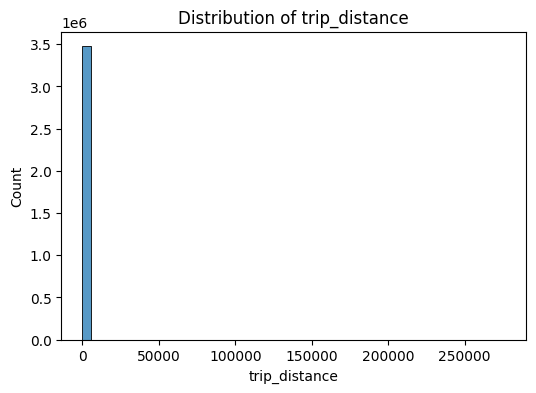

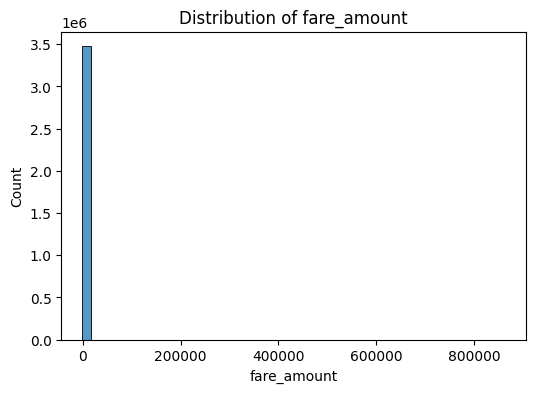

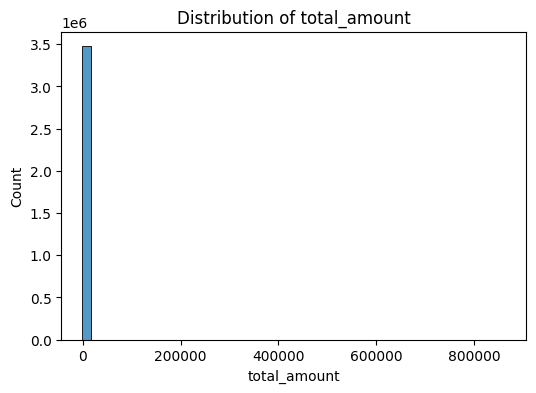

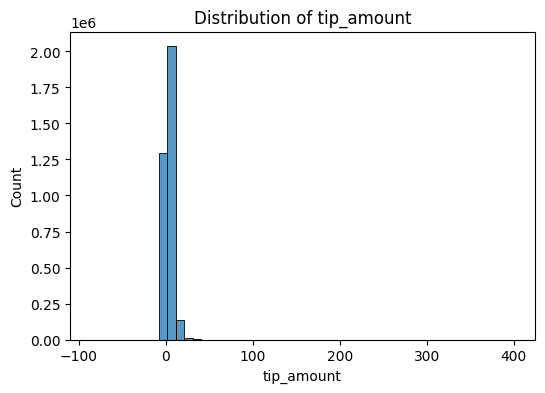

In [6]:
# Quick distribution checks for key numeric fields (if they exist)
numeric_cols = ['trip_distance', 'fare_amount', 'total_amount', 'tip_amount']

for col in numeric_cols:
    if col in df_raw.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_raw[col], kde=False, bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()


In [7]:
# Check for unrealistic or extreme values
if 'trip_distance' in df_raw.columns:
    print("Zero-distance trips:", (df_raw['trip_distance'] == 0).sum())

if 'fare_amount' in df_raw.columns:
    print("Negative fares:", (df_raw['fare_amount'] < 0).sum())
    print("Very high fares (> $300):", (df_raw['fare_amount'] > 300).sum())


Zero-distance trips: 90893
Negative fares: 144118
Very high fares (> $300): 327


In [8]:
# Check for unrealistic or extreme values
if 'trip_distance' in df_raw.columns:
    print("Zero-distance trips:", (df_raw['trip_distance'] == 0).sum())

if 'fare_amount' in df_raw.columns:
    print("Negative fares:", (df_raw['fare_amount'] < 0).sum())
    print("Very high fares (> $300):", (df_raw['fare_amount'] > 300).sum())


Zero-distance trips: 90893
Negative fares: 144118
Very high fares (> $300): 327


In [9]:
# Passenger Count EDA Summary

if "passenger_count" in df_raw.columns:
    print("Passenger Count Summary")
    print("------------------------")

    # Basic stats
    avg_pass = df_raw["passenger_count"].mean()
    med_pass = df_raw["passenger_count"].median()
    unique_pass = df_raw["passenger_count"].unique()

    print("Average passenger count:", avg_pass)
    print("Median passenger count:", med_pass)
    print("Unique passenger counts:", unique_pass)

    # Value counts
    print("\nPassenger Count Frequency:")
    print(df_raw["passenger_count"].value_counts(dropna=False))

    # Missing count
    print("\nMissing passenger_count values:", df_raw["passenger_count"].isna().sum())
else:
    print("Column 'passenger_count' not found in dataset.")


Passenger Count Summary
------------------------
Average passenger count: 1.2978589658806226
Median passenger count: 1.0
Unique passenger counts: [ 1.  3.  2.  0.  4.  9.  6.  5.  8.  7. nan]

Passenger Count Frequency:
passenger_count
1.0    2322434
NaN     540149
2.0     407761
3.0      91409
4.0      59009
0.0      24656
5.0      17786
6.0      12004
8.0         11
7.0          4
9.0          3
Name: count, dtype: int64

Missing passenger_count values: 540149


# Data Cleaning
---
- Remove rows with impossible or corrupted values (negative fares, negative distances, invalid timestamps).  
- Drop rows with missing critical fields needed for modeling.  
- Filter out extreme outliers that would distort linear model training.  
- Reset the index after cleaning to keep the dataset consistent.  
- Preserve a separate cleaned copy for preprocessing.



In [10]:
import pandas as pd
import numpy as np

df_clean = df_raw.copy()

# Remove negative or zero distances
if 'trip_distance' in df_clean.columns:
    df_clean = df_clean[df_clean['trip_distance'] > 0]

# Remove negative fare amounts
if 'fare_amount' in df_clean.columns:
    df_clean = df_clean[df_clean['fare_amount'] >= 0]

# Remove negative total amounts
if 'total_amount' in df_clean.columns:
    df_clean = df_clean[df_clean['total_amount'] >= 0]

# Clean passenger_count

if "passenger_count" in df_clean.columns:
    
    # Replace impossible values (>6 passengers)
    df_clean.loc[df_clean["passenger_count"] > 6, "passenger_count"] = np.nan

    # Replace negative or zero passengers
    df_clean.loc[df_clean["passenger_count"] <= 0, "passenger_count"] = np.nan

    # Impute NaN passenger_count with mode = 1
    df_clean["passenger_count"] = df_clean["passenger_count"].fillna(1)

    # Convert to integer
    df_clean["passenger_count"] = df_clean["passenger_count"].astype(int)

print("Passenger count cleaned. Unique values now:", df_clean["passenger_count"].unique())

# Drop rows missing essential columns (if present)
essential_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'trip_distance',
    'fare_amount',
    'payment_type'
]

existing_essential = [col for col in essential_cols if col in df_clean.columns]
df_clean = df_clean.dropna(subset=existing_essential)

# Remove extremely high outliers for modeling stability
if 'fare_amount' in df_clean.columns:
    df_clean = df_clean[df_clean['fare_amount'] <= 300]

# Convert datetime columns if present
datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
for col in datetime_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

# Drop rows with invalid datetime
for col in datetime_cols:
    if col in df_clean.columns:
        df_clean = df_clean.dropna(subset=[col])

# Reset index
df_clean = df_clean.reset_index(drop=True)

print("Cleaned DataFrame shape:", df_clean.shape)


Passenger count cleaned. Unique values now: [1 3 2 4 6 5]
Cleaned DataFrame shape: (3254210, 20)


# Data Preprocessing
---
- Select the main feature columns and drop unused fields.  
- Extract basic time features from the pickup timestamp.  
- One-hot encode categorical fields like `payment_type`.  
- Create targets for regression (`target_fare`) and classification (`target_tip`).  
- Leave scaling for after the train/test split to avoid data leakage.



In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df_pre = df_clean.copy()

# -----------------------------
# Time-based feature extraction
# -----------------------------
if 'tpep_pickup_datetime' in df_pre.columns:
    df_pre['pickup_hour'] = df_pre['tpep_pickup_datetime'].dt.hour
    df_pre['pickup_day'] = df_pre['tpep_pickup_datetime'].dt.day
    df_pre['pickup_weekday'] = df_pre['tpep_pickup_datetime'].dt.weekday

# -----------------------------
# Create target variables
# -----------------------------
if 'fare_amount' in df_pre.columns:
    df_pre['target_fare'] = df_pre['fare_amount']

if 'tip_amount' in df_pre.columns:
    df_pre['target_tip'] = (df_pre['tip_amount'] > 0).astype(int)

# -----------------------------
# Base numeric feature set
# -----------------------------
feature_cols = [
    'trip_distance',
    'pickup_hour',
    'pickup_day',
    'pickup_weekday',
    'passenger_count'
]

feature_cols = [c for c in feature_cols if c in df_pre.columns]
X = df_pre[feature_cols].copy()

# -----------------------------
# One-hot encode payment_type (if present)
# -----------------------------
if 'payment_type' in df_pre.columns:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    payment_ohe = ohe.fit_transform(df_pre[['payment_type']])
    payment_df = pd.DataFrame(
        payment_ohe,
        columns=[f"payment_{cat}" for cat in ohe.categories_[0]],
        index=df_pre.index
    )
    X = pd.concat([X, payment_df], axis=1)

# -----------------------------
# Define targets
# -----------------------------
y_fare = df_pre['target_fare'] if 'target_fare' in df_pre.columns else None
y_tip = df_pre['target_tip'] if 'target_tip' in df_pre.columns else None

print("Feature matrix shape (X):", X.shape)
if y_fare is not None:
    print("Regression target shape (y_fare):", y_fare.shape)
if y_tip is not None:
    print("Classification target shape (y_tip):", y_tip.shape)

# Keep preprocessed feature and target references
df_preprocessed_features = X.copy()
df_preprocessed_targets = df_pre[['target_fare', 'target_tip']].copy()


Feature matrix shape (X): (3254210, 10)
Regression target shape (y_fare): (3254210,)
Classification target shape (y_tip): (3254210,)


# Feature Engineering
---
- Add simple **time-based binary flags** using pickup time: `is_night`, `is_rush_hour`, `is_weekend`.  
- Add a **binned version of trip_distance** to capture non-linear distance effects without using post-trip info.  
- Keep only features that are realistically available **before** the trip starts (no dropoff-based fields, no duration or speed). Keeping those features would cause data leakage. 
- Append engineered features to the existing feature matrix `X` to produce the final pre-trip feature set.

In [12]:
import pandas as pd

# Start from preprocessed frame that already has pickup_* fields and targets
df_feat = df_pre.copy()

# -----------------------------
# Time-based flags (pre-trip safe)
# -----------------------------
# Night trips: 10pm–5am
if 'pickup_hour' in df_feat.columns:
    df_feat['is_night'] = df_feat['pickup_hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
else:
    df_feat['is_night'] = 0

# Rush hour: 7–9am and 4–7pm
if 'pickup_hour' in df_feat.columns:
    df_feat['is_rush_hour'] = df_feat['pickup_hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
else:
    df_feat['is_rush_hour'] = 0

# Weekend flag: Saturday (5) and Sunday (6)
if 'pickup_weekday' in df_feat.columns:
    df_feat['is_weekend'] = df_feat['pickup_weekday'].isin([5, 6]).astype(int)
else:
    df_feat['is_weekend'] = 0

# -----------------------------
# Trip distance bins (pre-trip safe)
# -----------------------------
# Bins: 0–1, 1–3, 3–7, 7–15, >15 miles
if 'trip_distance' in df_feat.columns:
    distance_bins = [0, 1, 3, 7, 15, float("inf")]
    distance_labels = ["0-1", "1-3", "3-7", "7-15", "15+"]

    df_feat['distance_bin'] = pd.cut(
        df_feat['trip_distance'],
        bins=distance_bins,
        labels=distance_labels,
        include_lowest=True,
        right=True
    )
else:
    df_feat['distance_bin'] = pd.NA

# One-hot encode distance_bin
if 'distance_bin' in df_feat.columns:
    distance_dummies = pd.get_dummies(df_feat['distance_bin'], prefix="dist", dummy_na=False)
else:
    distance_dummies = pd.DataFrame(index=df_feat.index)

# -----------------------------
# Build final feature matrix (pre-trip only)
# -----------------------------
# Start from existing numeric + payment_type features already in X
X_feat = X.copy()
X_feat = X_feat.reindex(df_feat.index)

# Add time-based flags
for col in ['is_night', 'is_rush_hour', 'is_weekend']:
    if col in df_feat.columns:
        X_feat[col] = df_feat[col]

# Add distance bin dummies
if not distance_dummies.empty:
    X_feat = pd.concat([X_feat, distance_dummies], axis=1)

print("Pre-trip feature matrix shape:", X_feat.shape)

# Keep final pre-trip engineered feature matrix
X = X_feat.copy()
df_engineered_pretrip = df_feat.copy()


Pre-trip feature matrix shape: (3254210, 18)


In [13]:
# Check for any NaNs in the feature matrix
total_nans = X.isna().sum().sum()
print("Total NaN values in X:", total_nans)

# Show NaNs by column (only columns that contain NaNs)
nans_by_column = X.isna().sum()
nans_by_column = nans_by_column[nans_by_column > 0]

print("\nColumns containing NaNs:")
print(nans_by_column if not nans_by_column.empty else "None")



Total NaN values in X: 0

Columns containing NaNs:
None


# Model Selection
---
- Define two prediction tasks: **fare regression** and **tip classification**.  
- Use **linear regression** (with Ridge/Lasso regularization) for fare prediction.  
- Use **logistic regression** (with L2 regularization) for tip prediction.  
- Create **train/validation/test splits** for both tasks, making sure no data leakage occurs.  
- Keep raw feature values here; scaling and GPU-based training will be handled in the next section.



In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# -----------------------------
# Filter rows with valid targets
# -----------------------------
mask_fare = y_fare.notna() if y_fare is not None else None
mask_tip = y_tip.notna() if y_tip is not None else None

# Common mask for rows where both tasks are valid (optional but simpler)
if (mask_fare is not None) and (mask_tip is not None):
    mask_both = mask_fare & mask_tip
    X_model = X[mask_both].reset_index(drop=True)
    y_fare_model = y_fare[mask_both].reset_index(drop=True)
    y_tip_model = y_tip[mask_both].reset_index(drop=True)
else:
    X_model = X.copy()
    y_fare_model = y_fare.copy() if y_fare is not None else None
    y_tip_model = y_tip.copy() if y_tip is not None else None

print("Final modeling feature shape:", X_model.shape)


Final modeling feature shape: (3254210, 18)


In [15]:
# -----------------------------
# Train / validation / test split
# -----------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # of the remaining training set

# First split: train+val vs test
X_tmp, X_test, y_fare_tmp, y_fare_test, y_tip_tmp, y_tip_test = train_test_split(
    X_model,
    y_fare_model,
    y_tip_model,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_tip_model  # stratify by classification target to keep class balance
)

# Second split: train vs validation
val_fraction_of_tmp = VAL_SIZE / (1.0 - TEST_SIZE)

X_train, X_val, y_fare_train, y_fare_val, y_tip_train, y_tip_val = train_test_split(
    X_tmp,
    y_fare_tmp,
    y_tip_tmp,
    test_size=val_fraction_of_tmp,
    random_state=RANDOM_STATE,
    stratify=y_tip_tmp
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

# -----------------------------
# Model choices (configuration only)
# -----------------------------
MODEL_CONFIG = {
    "fare_regression": {
        "type": "linear_regression_baseline",
        "regularized_variants": ["ridge", "lasso"]
    },
    "tip_classification": {
        "type": "logistic_regression",
        "penalty": "l2"
    }
}

MODEL_CONFIG

Train shape: (2277947, 18)
Val shape: (325421, 18)
Test shape: (650842, 18)


{'fare_regression': {'type': 'linear_regression_baseline',
  'regularized_variants': ['ridge', 'lasso']},
 'tip_classification': {'type': 'logistic_regression', 'penalty': 'l2'}}

# Model Training
---
- Scale features using a `StandardScaler` fit **only on the training set**.  
- Convert NumPy arrays to PyTorch tensors and move them to **GPU** if available.  
- Train a simple **linear regression model** for fare prediction with MSE loss.  
- Train a simple **logistic regression model** for tip prediction with BCE-with-logits loss.  
- Use mini-batch training with Adam optimizer and track training/validation loss for each model.



In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# Scaling (fit on train, apply to val/test)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# Convert to PyTorch tensors
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

y_fare_train_t = torch.tensor(y_fare_train.values, dtype=torch.float32).view(-1, 1)
y_fare_val_t = torch.tensor(y_fare_val.values, dtype=torch.float32).view(-1, 1)

y_tip_train_t = torch.tensor(y_tip_train.values, dtype=torch.float32).view(-1, 1)
y_tip_val_t = torch.tensor(y_tip_val.values, dtype=torch.float32).view(-1, 1)

# -----------------------------
# Dataloaders
# -----------------------------
BATCH_SIZE = 1024

fare_train_ds = TensorDataset(X_train_t, y_fare_train_t)
fare_val_ds = TensorDataset(X_val_t, y_fare_val_t)

tip_train_ds = TensorDataset(X_train_t, y_tip_train_t)
tip_val_ds = TensorDataset(X_val_t, y_tip_val_t)

fare_train_loader = DataLoader(fare_train_ds, batch_size=BATCH_SIZE, shuffle=True)
fare_val_loader = DataLoader(fare_val_ds, batch_size=BATCH_SIZE, shuffle=False)

tip_train_loader = DataLoader(tip_train_ds, batch_size=BATCH_SIZE, shuffle=True)
tip_val_loader = DataLoader(tip_val_ds, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# Model definitions
# -----------------------------
class LinearRegressor(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x)


class LogisticRegressor(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x)  # raw logits


input_dim = X_train_t.shape[1]

fare_model = LinearRegressor(input_dim).to(device)
tip_model = LogisticRegressor(input_dim).to(device)

# -----------------------------
# Training helper
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=4):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        print(
            f"Epoch {epoch:02d} | "
            f"Train loss: {np.mean(train_losses):.4f} | "
            f"Val loss: {np.mean(val_losses):.4f}"
        )
    return model


Using device: cuda


In [17]:
# -----------------------------
# Train fare regression model
# -----------------------------
fare_criterion = nn.MSELoss()
fare_optimizer = torch.optim.Adam(fare_model.parameters(), lr=1e-3)

print("Training fare regression model:")
fare_model = train_model(
    fare_model,
    fare_train_loader,
    fare_val_loader,
    fare_criterion,
    fare_optimizer,
    epochs=5,
)

Training fare regression model:
Epoch 01 | Train loss: 485.1001 | Val loss: 403.5853
Epoch 02 | Train loss: 340.7884 | Val loss: 284.2952
Epoch 03 | Train loss: 239.8351 | Val loss: 200.7138
Epoch 04 | Train loss: 169.6999 | Val loss: 142.7901
Epoch 05 | Train loss: 121.3625 | Val loss: 103.3884


In [19]:
# -----------------------------
# Train tip classification model
# -----------------------------
tip_criterion = nn.BCEWithLogitsLoss()
tip_optimizer = torch.optim.Adam(tip_model.parameters(), lr=1e-3)

print("\nTraining tip classification model:")
tip_model = train_model(
    tip_model,
    tip_train_loader,
    tip_val_loader,
    tip_criterion,
    tip_optimizer,
    epochs=5,
)


Training tip classification model:
Epoch 01 | Train loss: 0.2951 | Val loss: 0.2106
Epoch 02 | Train loss: 0.2087 | Val loss: 0.2064
Epoch 03 | Train loss: 0.2071 | Val loss: 0.2057
Epoch 04 | Train loss: 0.2068 | Val loss: 0.2054
Epoch 05 | Train loss: 0.2066 | Val loss: 0.2053


# Model Evaluation
---
- Evaluate the fare regression model using **RMSE**, **MAE**, and **R²** on the test set.  
- Evaluate the tip classification model using **accuracy**, **precision**, **recall**, **F1**, and **ROC-AUC**.  
- Convert PyTorch model outputs into NumPy arrays for compatibility with scikit-learn metrics.  
- Apply a sigmoid activation to logistic regression outputs before computing classification metrics.



In [20]:
import torch
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# -----------------------------
# Move tensors to CPU for evaluation
# -----------------------------
fare_model.eval()
tip_model.eval()

with torch.no_grad():
    # Fare regression predictions
    fare_preds_test = fare_model(X_test_t.to(device)).cpu().numpy().reshape(-1)
    fare_true_test = y_fare_test.values.reshape(-1)

    # Tip classification predictions (logits -> probabilities)
    tip_logits_test = tip_model(X_test_t.to(device)).cpu().numpy().reshape(-1)
    tip_probs_test = 1 / (1 + np.exp(-tip_logits_test))  # sigmoid
    tip_preds_test = (tip_probs_test >= 0.5).astype(int)
    tip_true_test = y_tip_test.values.reshape(-1)


In [21]:
# -----------------------------
# Regression Metrics
# -----------------------------
rmse = mean_squared_error(fare_true_test, fare_preds_test, squared=False)
mae = mean_absolute_error(fare_true_test, fare_preds_test)
r2 = r2_score(fare_true_test, fare_preds_test)

print("=== Fare Regression Metrics ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


=== Fare Regression Metrics ===
RMSE: 10.1532
MAE:  7.8006
R²:   0.5953


c:\Users\Gardi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# -----------------------------
# Classification Metrics
# -----------------------------
acc = accuracy_score(tip_true_test, tip_preds_test)
prec = precision_score(tip_true_test, tip_preds_test, zero_division=0)
rec = recall_score(tip_true_test, tip_preds_test, zero_division=0)
f1 = f1_score(tip_true_test, tip_preds_test, zero_division=0)
auc = roc_auc_score(tip_true_test, tip_probs_test)

print("\n=== Tip Classification Metrics ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")



=== Tip Classification Metrics ===
Accuracy:  0.9420
Precision: 0.9435
Recall:    0.9778
F1 Score:  0.9604
ROC-AUC:   0.9373


# Hyperparameter Tuning
---
- Tune **regularization strength** for linear models using scikit-learn on the scaled features.  
- For fare prediction, search over **Ridge** and **Lasso** with different `alpha` values.  
- For tip prediction, tune **LogisticRegression** with different `C` values (inverse regularization strength).  
- Use the validation set to pick the best hyperparameters, then report performance on the validation split.



In [23]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# -----------------------------
# Fare regression: Ridge and Lasso
# -----------------------------
alphas = [0.01, 0.1, 1.0, 10.0]

best_ridge_rmse = np.inf
best_ridge_model = None
best_ridge_alpha = None

for alpha in alphas:
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(X_train_scaled, y_fare_train)
    preds_val = model.predict(X_val_scaled)
    rmse_val = mean_squared_error(y_fare_val, preds_val, squared=False)

    if rmse_val < best_ridge_rmse:
        best_ridge_rmse = rmse_val
        best_ridge_model = model
        best_ridge_alpha = alpha

best_lasso_rmse = np.inf
best_lasso_model = None
best_lasso_alpha = None

for alpha in alphas:
    model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    model.fit(X_train_scaled, y_fare_train)
    preds_val = model.predict(X_val_scaled)
    rmse_val = mean_squared_error(y_fare_val, preds_val, squared=False)

    if rmse_val < best_lasso_rmse:
        best_lasso_rmse = rmse_val
        best_lasso_model = model
        best_lasso_alpha = alpha

print("=== Hyperparameter Tuning: Fare Regression ===")
print(f"Best Ridge alpha: {best_ridge_alpha} | Val RMSE: {best_ridge_rmse:.4f}")
print(f"Best Lasso alpha: {best_lasso_alpha} | Val RMSE: {best_lasso_rmse:.4f}")

# Choose the better of Ridge/Lasso on validation RMSE
if best_ridge_rmse <= best_lasso_rmse:
    best_fare_sklearn_model = best_ridge_model
    best_fare_model_type = f"Ridge(alpha={best_ridge_alpha})"
else:
    best_fare_sklearn_model = best_lasso_model
    best_fare_model_type = f"Lasso(alpha={best_lasso_alpha})"

print("Selected fare model:", best_fare_model_type)

# -----------------------------
# Tip classification: Logistic Regression
# -----------------------------
Cs = [0.01, 0.1, 1.0, 10.0]

best_log_acc = -np.inf
best_log_model = None
best_log_C = None

for C in Cs:
    clf = LogisticRegression(
        C=C,
        penalty="l2",
        solver="lbfgs",
        max_iter=500,
        n_jobs=3
    )
    clf.fit(X_train_scaled, y_tip_train)
    preds_val = clf.predict(X_val_scaled)
    acc_val = accuracy_score(y_tip_val, preds_val)

    if acc_val > best_log_acc:
        best_log_acc = acc_val
        best_log_model = clf
        best_log_C = C

print("\n=== Hyperparameter Tuning: Tip Classification ===")
print(f"Best LogisticRegression C: {best_log_C} | Val Accuracy: {best_log_acc:.4f}")

best_tip_sklearn_model = best_log_model
best_tip_model_type = f"LogisticRegression(C={best_log_C})"
print("Selected tip model:", best_tip_model_type)



c:\Users\Gardi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Gardi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Gardi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Gardi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

=== Hyperparameter Tuning: Fare Regression ===
Best Ridge alpha: 0.01 | Val RMSE: 6.7219
Best Lasso alpha: 0.01 | Val RMSE: 6.7221
Selected fare model: Ridge(alpha=0.01)

=== Hyperparameter Tuning: Tip Classification ===
Best LogisticRegression C: 0.01 | Val Accuracy: 0.9423
Selected tip model: LogisticRegression(C=0.01)


# Final Training & Test Evaluation
---
- Retrain the **best-tuned linear models** on the combined **train + validation** data.  
- Fit a fresh `StandardScaler` on the combined train + validation features and apply it to both train+val and test sets.  
- For fare prediction, retrain the chosen **Ridge or Lasso** model using the best `alpha`.  
- For tip prediction, retrain **LogisticRegression** using the best `C`.  
- Evaluate the final models on the **held-out test set** to get unbiased performance metrics before deployment.



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# -----------------------------
# Combine train + validation splits
# -----------------------------
X_train_val = np.concatenate([X_train, X_val], axis=0)
y_fare_train_val = np.concatenate([y_fare_train.values, y_fare_val.values], axis=0)
y_tip_train_val = np.concatenate([y_tip_train.values, y_tip_val.values], axis=0)

print("Train+Val shape:", X_train_val.shape)

# -----------------------------
# Final scaling (fit on train+val, apply to test)
# -----------------------------
final_scaler = StandardScaler()
X_train_val_scaled = final_scaler.fit_transform(X_train_val)
X_test_scaled_final = final_scaler.transform(X_test)

# -----------------------------
# Rebuild final fare model with best hyperparameters
# -----------------------------
if "Ridge" in best_fare_model_type:
    final_fare_model = Ridge(alpha=best_ridge_alpha, random_state=42)
elif "Lasso" in best_fare_model_type:
    final_fare_model = Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=10000)
else:
    # Fallback: use Ridge with default alpha if something is off
    final_fare_model = Ridge(alpha=1.0, random_state=42)

final_fare_model.fit(X_train_val_scaled, y_fare_train_val)

# -----------------------------
# Rebuild final tip model with best hyperparameters
# -----------------------------
final_tip_model = LogisticRegression(
    C=best_log_C,
    penalty="l2",
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1,
)
final_tip_model.fit(X_train_val_scaled, y_tip_train_val)

# -----------------------------
# Final evaluation on test set
# -----------------------------
# Fare regression predictions
fare_test_preds = final_fare_model.predict(X_test_scaled_final)
fare_test_true = y_fare_test.values

fare_rmse = mean_squared_error(fare_test_true, fare_test_preds, squared=False)
fare_mae = mean_absolute_error(fare_test_true, fare_test_preds)
fare_r2 = r2_score(fare_test_true, fare_test_preds)

print("=== Final Fare Regression (Test) ===")
print(f"RMSE: {fare_rmse:.4f}")
print(f"MAE:  {fare_mae:.4f}")
print(f"R²:   {fare_r2:.4f}")

# Tip classification predictions
tip_test_probs = final_tip_model.predict_proba(X_test_scaled_final)[:, 1]
tip_test_preds = (tip_test_probs >= 0.5).astype(int)
tip_test_true = y_tip_test.values

tip_acc = accuracy_score(tip_test_true, tip_test_preds)
tip_prec = precision_score(tip_test_true, tip_test_preds, zero_division=0)
tip_rec = recall_score(tip_test_true, tip_test_preds, zero_division=0)
tip_f1 = f1_score(tip_test_true, tip_test_preds, zero_division=0)
tip_auc = roc_auc_score(tip_test_true, tip_test_probs)

print("\n=== Final Tip Classification (Test) ===")
print(f"Accuracy:  {tip_acc:.4f}")
print(f"Precision: {tip_prec:.4f}")
print(f"Recall:    {tip_rec:.4f}")
print(f"F1 Score:  {tip_f1:.4f}")
print(f"ROC-AUC:   {tip_auc:.4f}")

# Model Deployment
---
- Export the trained PyTorch models and the tuned scikit-learn models.  
- Save the `StandardScaler` used for preprocessing so new data can be transformed consistently.  
- Build a simple **in-notebook prediction function** that takes raw trip details and returns:  
  - predicted fare  
  - predicted tip probability  
- Prepare a minimal **FastAPI-style endpoint template** (not running a server here, just generating reusable code).  
- Keep deployment lightweight and focused on demonstrating how the model would be used in an app.



In [ ]:
import joblib
import torch
import os

# -----------------------------
# Create deployment directory
# -----------------------------
os.makedirs("app/deployment", exist_ok=True)

# -----------------------------
# Save final tuned + retrained sklearn models
# -----------------------------
joblib.dump(final_fare_model, "app/deployment/fare_model_sklearn.pkl")
joblib.dump(final_tip_model, "app/deployment/tip_model_sklearn.pkl")

# -----------------------------
# Save final scaler (fit on train+val)
# -----------------------------
joblib.dump(final_scaler, "app/deployment/scaler.pkl")

# -----------------------------
# OPTIONAL: Save PyTorch baseline models
# (Only do this if you plan to deploy the PyTorch versions.)
# -----------------------------
torch.save(fare_model.state_dict(), "app/deployment/fare_model_pt_baseline.pth")
torch.save(tip_model.state_dict(), "app/deployment/tip_model_pt_baseline.pth")

print("Saved deployment assets:")
print(os.listdir("app/deployment"))


Saved deployment assets:
['fare_model_pt.pth', 'fare_model_sklearn.pkl', 'scaler.pkl', 'tip_model_pt.pth', 'tip_model_sklearn.pkl']


### In-Notebook Prediction Function
This function accepts raw trip info, builds a pre-trip feature vector, scales it, and returns predicted fare and tip probability.



In [26]:
import numpy as np
import pandas as pd

def predict_trip(fare_model_pt, tip_model_pt, scaler, sample_dict):
    """
    sample_dict example:
    {
        "trip_distance": 2.3,
        "passenger_count": 1,
        "pickup_hour": 14,
        "pickup_day": 12,
        "pickup_weekday": 3,
        "payment_type": "Credit card"
    }
    """

    df = pd.DataFrame([sample_dict])

    # Time flags
    df['is_night'] = df['pickup_hour'].isin([22,23,0,1,2,3,4,5]).astype(int)
    df['is_rush_hour'] = df['pickup_hour'].isin([7,8,9,16,17,18,19]).astype(int)
    df['is_weekend'] = df['pickup_weekday'].isin([5,6]).astype(int)

    # Distance bins
    bins = [0,1,3,7,15,float("inf")]
    labels = ["0-1","1-3","3-7","7-15","15+"]
    df['distance_bin'] = pd.cut(df['trip_distance'], bins=bins, labels=labels, include_lowest=True)

    # One-hot encode distance_bin
    distance_dummies = pd.get_dummies(df['distance_bin'], prefix="dist")

    # One-hot encode payment_type
    payment_dummies = pd.get_dummies(df['payment_type'], prefix="payment")

    # Align with model training columns
    full = pd.concat([df, distance_dummies, payment_dummies], axis=1)
    full = full.reindex(columns=X.columns, fill_value=0)

    # Scale
    X_scaled = scaler.transform(full)
    X_t = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    # Fare prediction
    fare_model_pt.eval()
    with torch.no_grad():
        fare_pred = fare_model_pt(X_t).cpu().numpy().flatten()[0]

    # Tip prediction (sigmoid)
    tip_model_pt.eval()
    with torch.no_grad():
        tip_logit = tip_model_pt(X_t).cpu().numpy().flatten()[0]
        tip_prob = 1 / (1 + np.exp(-tip_logit))

    return {
        "predicted_fare": float(fare_pred),
        "tip_probability": float(tip_prob)
    }

# Example usage
sample_input = {
    "trip_distance": 2.3,
    "passenger_count": 1,
    "pickup_hour": 14,
    "pickup_day": 12,
    "pickup_weekday": 3,
    "payment_type": "Credit card"
}

predict_trip(fare_model, tip_model, scaler, sample_input)


{'predicted_fare': 5.782572269439697, 'tip_probability': 0.46278558857282703}

### FastAPI Deployment Template
A lightweight template showing how this model would be deployed behind an API.  
This is **pre-written code**, not executed in this notebook.



In [28]:
# fastapi_app.py (not executed here)

from fastapi import FastAPI
import joblib
import torch
import numpy as np
import pandas as pd

app = FastAPI()

# Load assets
scaler = joblib.load("app/deployment/scaler.pkl")
fare_pt = torch.load("app/deployment/fare_model_pt.pth")
tip_pt = torch.load("app/deployment/tip_model_pt.pth")
fare_model = LinearRegressor(input_dim)
tip_model = LogisticRegressor(input_dim)
fare_model.load_state_dict(fare_pt)
tip_model.load_state_dict(tip_pt)

@app.post("/predict")
def predict(data: dict):
    result = predict_trip(fare_model, tip_model, scaler, data)
    return result


In [29]:
import joblib
from pathlib import Path

deploy_dir = Path("app/deployment")  # adjust if needed
deploy_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(list(X.columns), deploy_dir / "feature_columns.pkl")


['app\\deployment\\feature_columns.pkl']